In [1]:
import functools
import math
import pandas as pd
import tqdm
import numpy as np
import pickle

import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [2]:
def t_factory(l):
    if l in ('mine', 'imine', 'minef', 'tuba', ):
        return lambda df: np.average(df[0].joint_value[-1000:])
    elif l in ('nwj', ):
        return lambda df: np.average(df[0].joint_value[-1000:] - 1.0)
    raise Exception()

def et_factory(l):
    if l in ('mine', 'imine', ):
        return lambda df: np.log(np.average(np.exp(df[0].marginal_value[-1000:])))
    elif l in ('minef', 'nwj', ):
        return lambda df: np.average(np.exp(df[0].marginal_value[-1000:] - 1.0))
    elif l in ('tuba', ):
        return lambda df: np.average(np.exp(df[0].marginal_value[-1000:]))
    raise Exception()

def mi_factory(l):
    _t, _et = t_factory(l), et_factory(l)
    if l in ('mine', 'imine', 'minef', ):
        return lambda df: _t(df)-_et(df)
    elif l in ('tuba', 'nwj', ):
        return lambda df: _t(df)-_et(df)+1.0

rws = [
    '0.0%d'%i for i in range(1, 10)
] + [
    '0.%d'%i for i in range(1, 10)
] + [
    '%d.0'%i for i in range(1, 11)
]
bss = list(range(1, 101))

In [3]:
imine_experiment_results = {}

for bs in bss:
    for rw in rws:
        t, et, mi = t_factory('imine'), et_factory('imine'), mi_factory('imine')
        df = pickle.load(open(f'single_history/{rw}/{bs}/0.pkl', 'rb'))
        d = {'t': t(df), 'et': et(df), 'mi': mi(df), }

        imine_experiment_results[(int(bs), rw)] = d

/home1/irteam/users/siyeong/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


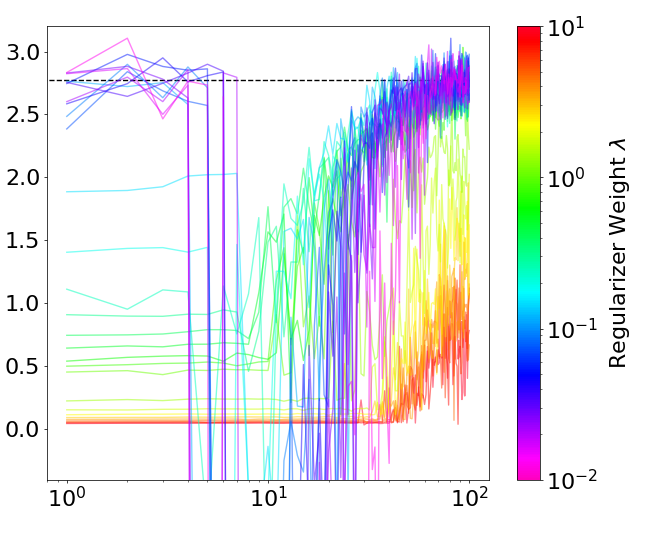

In [82]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rc('font', size=24)
plt.rcParams["figure.figsize"] = (10, 8)

title = 'mi'

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_rainbow(np.linspace(0, 1, 29))))


for rw in rws[::-1]:
    x = []
    y = []
    for bs in bss:
        x.append(bs)
        y.append(imine_experiment_results[(bs, rw)][title])
    plt.plot(x, y, label=rw if rw in ('0.01', '0.1', '1.0', '10.0') else '_nolegend_', alpha=0.5)

plt.hlines((math.log(16), -math.log(16)), xmin=0, xmax=max(bss), linestyles='--')
plt.xscale('log')
plt.xticks([1, 10, 100])
if title == 'mi':
    plt.ylim(-0.4, 3.2)
elif title == 't':
    plt.ylim(-1, 60)
elif title == 'et':
    plt.ylim(-4, 100)


linecolo = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(0.01, 10), cmap='gist_rainbow_r'))
linecolo.set_label(r'Regularizer Weight $\lambda$')
linecolo.ax.set_position([0.8, 0.1, 0.2, 0.839])
linecolo.ax.yaxis.set_label_coords(4, 0.5)

plt.tight_layout()
plt.subplots_adjust(left=0.07, right=0.9, bottom=0.1, top=0.95)
plt.show()
